### Develop a character based neural language model

A language model predicts the next word in the sequence based on the specific words that have
come before it in the sequence.  

Tasks:
- Prepare text for character-based language modeling.
- Develop a character-based language model using LSTMs.
- Use a trained character-based language model to generate text.


In [59]:
import numpy as np
from pickle import dump
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pickle import load
from keras.preprocessing.sequence import pad_sequences
import os
from IPython.display import Image
os.environ["PATH"] += os.pathsep +  'C:\\Users/richard\\Anaconda3\\pkgs\\graphviz-2.38-hfd603c8_2\\Library\\bin\\graphviz'



**Try using following nursery rhyme as our language model:**

Sing a song of sixpence,
A pocket full of rye.
Four and twenty blackbirds,
Baked in a pie.

When the pie was opened
The birds began to sing;
Wasn't that a dainty dish,
To set before the king.

The king was in his counting house,
Counting out his money;
The queen was in the parlour,
Eating bread and honey.

The maid was in the garden,
Hanging out the clothes,
When down came a blackbird
And pecked off her nose.

**saved as rhyme.txt**

In [60]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

In [61]:
filename = 'rhyme.txt'
text = load_doc(filename)
print(text)

Sing a song of sixpence,
A pocket full of rye.
Four and twenty blackbirds,
Baked in a pie.

When the pie was opened
The birds began to sing;
Wasn't that a dainty dish,
To set before the king.

The king was in his counting house,
Counting out his money;
The queen was in the parlour,
Eating bread and honey.

The maid was in the garden,
Hanging out the clothes,
When down came a blackbird
And pecked off her nose.


In [62]:
#one sequnce of lower case chars
tokens = text.split()
raw_text = ' '.join(tokens)

In [63]:
raw_text

"Sing a song of sixpence, A pocket full of rye. Four and twenty blackbirds, Baked in a pie. When the pie was opened The birds began to sing; Wasn't that a dainty dish, To set before the king. The king was in his counting house, Counting out his money; The queen was in the parlour, Eating bread and honey. The maid was in the garden, Hanging out the clothes, When down came a blackbird And pecked off her nose."

### Create Sequences

In [64]:
#make a sliding window,of 11 chars, first 10 will be input, last one the output  
length = 10
sequences = list()
for i in range(length,len(raw_text)):
    seq = raw_text[i-length:i+1]
    sequences.append(seq)
print('Total Sequences: %d' % len(sequences))
sequences[0:5]

Total Sequences: 399


['Sing a song', 'ing a song ', 'ng a song o', 'g a song of', ' a song of ']

In [65]:
sequences[0:5]

['Sing a song', 'ing a song ', 'ng a song o', 'g a song of', ' a song of ']

In [66]:
#make function to save sequnces
def save_doc(lines,filename):
    data = '\n'.join(lines)
    file = open(filename,'w')
    file.write(data)
    file.close()

In [67]:
#save sequences
out_filename = 'char_sequences.txt'
save_doc(sequences,out_filename)

In [68]:
filename = 'char_sequences.txt'
text = load_doc(filename)
print(text[:20])

Sing a song
ing a so


### Train Language Model
The model will read encoded characters and predict the next character in the sequence. A Long
Short-Term Memory recurrent neural network hidden layer will be used to learn the context
from the input sequence in order to make the predictions.

In [69]:
#load the sequences
# load
in_filename = 'char_sequences.txt'
raw_text = load_doc(in_filename)
lines = raw_text.split('\n')

In [70]:
lines[0:10]

['Sing a song',
 'ing a song ',
 'ng a song o',
 'g a song of',
 ' a song of ',
 'a song of s',
 ' song of si',
 'song of six',
 'ong of sixp',
 'ng of sixpe']

### Encode Sequences
The sequences of characters must be encoded as integers. This means that each unique character
will be assigned a specific integer value and each sequence of characters will be encoded as a
sequence of integers. We can create the mapping given a sorted set of unique characters in the
raw input data. The mapping is a dictionary of character values to integer values

In [71]:
chars = sorted(list(set(raw_text)))
print(chars)

['\n', ' ', "'", ',', '.', ';', 'A', 'B', 'C', 'E', 'F', 'H', 'S', 'T', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'w', 'x', 'y']


In [72]:
mapping = dict((c,i) for i,c in enumerate(chars))
print(mapping)

{'\n': 0, ' ': 1, "'": 2, ',': 3, '.': 4, ';': 5, 'A': 6, 'B': 7, 'C': 8, 'E': 9, 'F': 10, 'H': 11, 'S': 12, 'T': 13, 'W': 14, 'a': 15, 'b': 16, 'c': 17, 'd': 18, 'e': 19, 'f': 20, 'g': 21, 'h': 22, 'i': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'o': 28, 'p': 29, 'q': 30, 'r': 31, 's': 32, 't': 33, 'u': 34, 'w': 35, 'x': 36, 'y': 37}


In [73]:
#process each sequence of chars, use dictionary mapping to look up int value for each char
sequences = []
for line in lines:
    encoded_seq = [mapping[char] for char in line]
    sequences.append(encoded_seq)

In [74]:
print("Sequence: ",lines[0])
print("Correponding integer values: ",sequences[0])

Sequence:  Sing a song
Correponding integer values:  [12, 23, 27, 21, 1, 15, 1, 32, 28, 27, 21]


In [75]:
# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 38


### Split Inputs and Outputs

In [76]:
#Separate the columns into input andoutput sequences of characters
print(sequences[0:4])

[[12, 23, 27, 21, 1, 15, 1, 32, 28, 27, 21], [23, 27, 21, 1, 15, 1, 32, 28, 27, 21, 1], [27, 21, 1, 15, 1, 32, 28, 27, 21, 1, 28], [21, 1, 15, 1, 32, 28, 27, 21, 1, 28, 20]]


In [77]:
import numpy as np
sequences = np.array(sequences)

In [78]:
print(sequences.shape)
print(sequences[:4])

(399, 11)
[[12 23 27 21  1 15  1 32 28 27 21]
 [23 27 21  1 15  1 32 28 27 21  1]
 [27 21  1 15  1 32 28 27 21  1 28]
 [21  1 15  1 32 28 27 21  1 28 20]]


In [79]:
#get every row and all but last column as input
#get output as last entry in every row
X,y = sequences[:,:-1],sequences[:,-1]

One hot encode each character. Each character becomes a vector as
long as the vocabulary with a 1 marked for the specific character. Provides a clear objective for the
network to predict, where a probability distribution over characters can be output by the model
and compared to the ideal case of all 0 values with a 1 for the actual next character. Use the to categorical() function in the Keras API to one hot encode the input and output
sequences.

In [80]:
sequences = [to_categorical(x,num_classes=vocab_size) for x in X]
#X = np.array(sequences)
#y = to_categorical(y, num_classes=vocab_size)

In [81]:
#each entry encoded as array with 1 at integer value
print(X[0])
print(sequences[0])

[12 23 27 21  1 15  1 32 28 27]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

In [82]:
X = np.array(sequences)
y = to_categorical(y, num_classes=vocab_size)

### Fit Model
The model is defined with an input layer that takes sequences that have 10 time steps and vocab size
features for the one hot encoded input sequences. Specify these numbers, we use
the second and third dimensions on the X input data. This is so that if we change the length of
the sequences or size of the vocabulary, we do not need to change the model definition. The
model has a single LSTM hidden layer with 75 memory cells, chosen with a little trial and
error. The model has a fully connected output layer that outputs one vector with a probability
distribution across all characters in the vocabulary. A softmax activation function is used on
the output layer to ensure the output has the properties of a probability distribution

In [83]:
X.shape

(399, 10, 38)

In [84]:
#define the model
def define_model(X):
    model = Sequential()
    model.add(LSTM(75,input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(vocab_size,activation='softmax'))
    #compile the model
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['accuracy'])
    model.summary()
    plot_model(model,to_file='img/model18.png',show_shapes=True)
    return model

A multiclass classification problem, therefore we use the categorical log
loss. The efficient Adam implementation of gradient descent
is used to optimize the model and accuracy is reported at the end of each batch update. The model is fit for 100 training epochs, again found with a little trial and error. Running this prints
a summary of the defined network as a sanity check.

In [85]:
model = define_model(X)
# fit model
model.fit(X, y, epochs=100, verbose=2)
# save the model to file
model.save('model.h5')
# save the mapping
dump(mapping, open('mapping.pkl', 'wb'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 75)                34200     
_________________________________________________________________
dense_2 (Dense)              (None, 38)                2888      
Total params: 37,088
Trainable params: 37,088
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 1s - loss: 3.6145 - acc: 0.0702
Epoch 2/100
 - 0s - loss: 3.5191 - acc: 0.1855
Epoch 3/100
 - 0s - loss: 3.2231 - acc: 0.1905
Epoch 4/100
 - 0s - loss: 3.0865 - acc: 0.1905
Epoch 5/100
 - 0s - loss: 3.0234 - acc: 0.1905
Epoch 6/100
 - 0s - loss: 2.9978 - acc: 0.1905
Epoch 7/100
 - 0s - loss: 2.9750 - acc: 0.1905
Epoch 8/100
 - 0s - loss: 2.9650 - acc: 0.1905
Epoch 9/100
 - 0s - loss: 2.9450 - acc: 0.1905
Epoch 10/100
 - 0s - loss: 2.9333 - acc: 0.1905
Epoch 11/100
 - 0s - loss: 2.9049 - acc: 0.1905
Epoch 12/100
 -

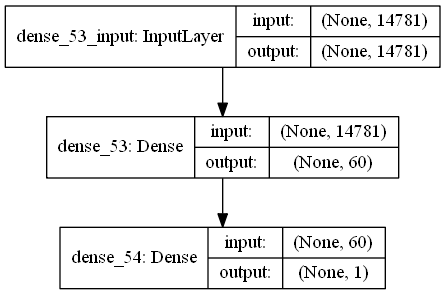

In [86]:
Image("img/model.png",width = 400)

### Save model


In [87]:
model.save('model.h5')
# save the mapping
dump(mapping, open('mapping.pkl', 'wb'))


### Generate Text

In [88]:
# load the model
model = load_model('model.h5')
# load the mapping
mapping = pickle.load(open('mapping.pkl', 'rb'))

In [89]:
print(mapping)

{'\n': 0, ' ': 1, "'": 2, ',': 3, '.': 4, ';': 5, 'A': 6, 'B': 7, 'C': 8, 'E': 9, 'F': 10, 'H': 11, 'S': 12, 'T': 13, 'W': 14, 'a': 15, 'b': 16, 'c': 17, 'd': 18, 'e': 19, 'f': 20, 'g': 21, 'h': 22, 'i': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'o': 28, 'p': 29, 'q': 30, 'r': 31, 's': 32, 't': 33, 'u': 34, 'w': 35, 'x': 36, 'y': 37}


In [90]:
#will predict character after 10th
in_text1 = 'sing a son'
in_text2 = 'king was i'
#random text
in_text3 = 'the man wa'

In [91]:
#using the mapping encode chars as integers
encoded = [mapping[char] for char in in_text1]
encoded

[32, 23, 27, 21, 1, 15, 1, 32, 28, 27]

In [92]:
seq_length = 10;n_chars= 20
#truncate to fixed length
encoded = pad_sequences([encoded],maxlen=seq_length,truncating='pre')
encoded

array([[32, 23, 27, 21,  1, 15,  1, 32, 28, 27]])

In [93]:
#one hot encode
encoded = to_categorical(encoded,num_classes=len(mapping))
encoded.shape

(1, 10, 38)

In [94]:
# generate a sequence of characters with a language model
def generate_seq(model, mapping, seq_length, seed_text, n_chars):
    in_text = seed_text
    # generate a fixed number of characters
    for _ in range(n_chars):
        # encode the characters as integers
        encoded = [mapping[char] for char in in_text]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # one hot encode
        encoded = to_categorical(encoded, num_classes=len(mapping))
        # predict character
        yhat = model.predict_classes(encoded, verbose=0)
        # reverse map integer to character
        out_char = ''
        for char, index in mapping.items():
            if index == yhat:
                out_char = char
                break
            # append to input
        in_text += out_char
    return in_text

In [98]:
# test start of rhyme
print(generate_seq(model, mapping, 10, 'Sing a son', 20))
print(generate_seq(model, mapping, 10, 'when the p', 20))
print(generate_seq(model, mapping, 10, 'king was i', 20))
# test not in original
print(generate_seq(model, mapping, 10, 'hello worl', 20))


Sing a song of sixpence, A poc
when the pberofre laaggin ttnt
king was in his counting house
hello worl, , aeeg ine  oasir 


preidcts two out of the three original text corretly, one is not, why is this? further action is required.  New text is nonsense 